In [1]:
import pandas as pd
from exosyspop.populations import BinaryPopulation
from exosyspop.populations import TRILEGAL_BGBinaryPopulation
from exosyspop.populations import KeplerBinaryPopulation, PoissonPlanetPopulation
from exosyspop.populations import KeplerPowerLawBinaryPopulation
from exosyspop.populations import PopulationMixture

targets = pd.read_hdf('targets.h5')
bgstars = pd.read_hdf('bgstars.h5')

# Sanitize dtypes of targets DataFrame
for c in targets.columns:
    if targets[c].dtype == object:
        targets.loc[:,c] = targets.loc[:,c].astype(str)


import logging
rootLogger = logging.getLogger()

In [2]:
#pop = KeplerPowerLawBinaryPopulation(targets)
#pop._train_trap()
#pop.save('pl_pop')
pop = KeplerPowerLawBinaryPopulation.load('pl_pop')
catalog = pop.observe(new=True, regr_trap=True)

In [3]:
pop.params

{'beta': -0.75,
 'beta_a': 0.8,
 'beta_b': 2.0,
 'fB': 0.15,
 'gamma': 0.3,
 'period_max': 7300,
 'period_min': 5,
 'qmin': 0.1}

In [4]:
import sys
sys.path.append('..')

from simpleabc.simple_abc import Model, basic_abc, pmc_abc
from scipy.stats import gaussian_kde, entropy, anderson_ksamp, uniform
import numpy as np

class PopulationModel(Model):
    """
    Test model for stellar binary population where parameters are fB, beta
    """
    def __init__(self, poplist):
        self.poplist = poplist        
        self.period_min = poplist.params['period_min']
        self.period_max = poplist.params['period_max']
        
    prior = [uniform(0,1), uniform(-1, 1.5)]
        
    def draw_theta(self):
        """ Draw parameters from prior
        """
        return [p.rvs() for p in self.prior]
        
    def generate_data(self, theta):
        """Generates synthetic catalog
        """
        fB, beta = theta
        self.poplist.set_params(fB=fB, beta=beta)
        return self.poplist.observe()
        
    def summary_stats(self, data):
        """Computes summary statistics from data
        """
        N = len(data)
        
        try:
            Pmin, Pmax = np.log(self.period_min), np.log(self.period_max)
            Pgrid = np.linspace(Pmin, Pmax, 1000)
            if N > 1:
                k = gaussian_kde(np.log(data.period.values))
                p = k(Pgrid)
            else:
                p = np.ones(len(Pgrid))*1./(Pmax - Pmin)
        except ValueError:
            print(data.period.values)
            raise
        
        return p, N
        
    def distance_function(self, summary_stats, summary_stats_synth):
        """Computes distance
        """
        p1, N1 = summary_stats
        p2, N2 = summary_stats_synth
        
        kl_period = entropy(p1, p2)
        if N1==0. or N2==0.:
            Ndist = 1.
        else:
            Ndist = max(1 - 1.*N1/N2, 1-1.*N2/N1)

        return kl_period + Ndist
        



In [5]:
model = PopulationModel(PopulationMixture([pop]))
theta_0 = 0.2, -0.75
data = model.generate_data(theta_0)
model.set_data(data)

In [6]:
posterior = basic_abc(model, data, min_samples=100, epsilon=0.5, verbose=True)

20 samples accepted (0.20%).
34 samples accepted (0.17%).
51 samples accepted (0.17%).
72 samples accepted (0.18%).
89 samples accepted (0.18%).


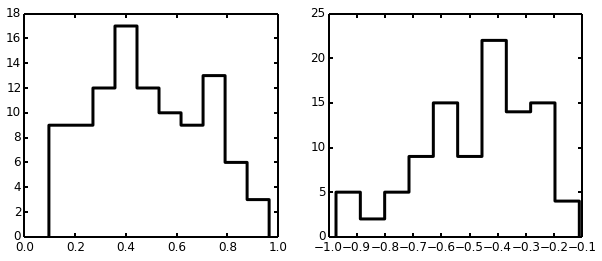

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1,2, figsize=(10,4))
hist_kwargs = dict(histtype='step', lw=3, color='k')
axes[0].hist(posterior[0][0], **hist_kwargs);
axes[1].hist(posterior[0][1], **hist_kwargs);


In [7]:
pmc_posterior = pmc_abc(model, data, epsilon_0=0.5, min_samples=200, steps=15, verbose=True)

Starting step 0
14 samples accepted (14.0%).
32 samples accepted (16.0%).
55 samples accepted (18.3%).
75 samples accepted (18.8%).
91 samples accepted (18.2%).
107 samples accepted (17.8%).
130 samples accepted (18.6%).
152 samples accepted (19.0%).
170 samples accepted (18.9%).
185 samples accepted (18.5%).
199 samples accepted (18.1%).
Starting step 1
33 samples accepted (33.0%).
66 samples accepted (33.0%).
101 samples accepted (33.7%).
136 samples accepted (34.0%).
174 samples accepted (34.8%).
Starting step 2
37 samples accepted (37.0%).
62 samples accepted (31.0%).
98 samples accepted (32.7%).
117 samples accepted (29.2%).
143 samples accepted (28.6%).
176 samples accepted (29.3%).
Starting step 3
29 samples accepted (29.0%).
60 samples accepted (30.0%).
94 samples accepted (31.3%).
126 samples accepted (31.5%).
161 samples accepted (32.2%).
191 samples accepted (31.8%).
Starting step 4
24 samples accepted (24.0%).
56 samples accepted (28.0%).
83 samples accepted (27.7%).
104 sa

In [8]:
pmc_posterior

array([ ([[0.35485879395855335, 0.44277320413112364, 0.8536391447512756, 0.15161931043497479, 0.8159066283888838, 0.8471734276370888, 0.5411730032137898, 0.4370592754356448, 0.6120971201253663, 0.4184350484803063, 0.6912196731860357, 0.152091145632277, 0.6356192385906322, 0.2958139437296913, 0.23966090566744458, 0.11816094604820981, 0.11512672421446113, 0.13781626472751818, 0.7452976577056222, 0.29591992274011214, 0.5472569635914943, 0.19230654741615705, 0.1270771073317648, 0.29924217938703634, 0.7043711951444543, 0.4229860335801138, 0.3823508222690102, 0.8934620913305251, 0.8255174372302717, 0.7753447974423163, 0.9194561514207594, 0.22501505947166212, 0.2154868598412235, 0.36692857707512105, 0.4939963212309597, 0.48841609775196915, 0.8553290900063482, 0.8919066240657125, 0.24329216771058715, 0.8854978548726316, 0.9990074232669911, 0.8506176567065742, 0.3582700552657557, 0.47406953964862086, 0.22258951016779605, 0.3476425208682845, 0.2558747981552917, 0.1748451399003439, 0.819400515625

In [9]:
type(pmc_posterior)

numpy.ndarray

In [10]:
pmc_posterior.shape

(15,)

In [14]:
pmc_posterior[-1]['epsilon']

0.039502122789349031

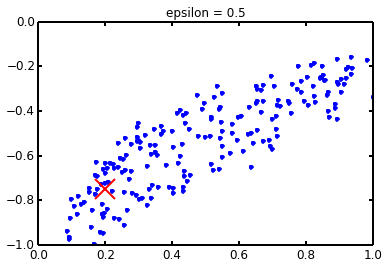

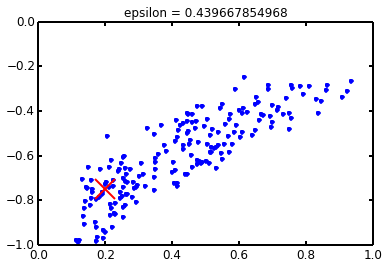

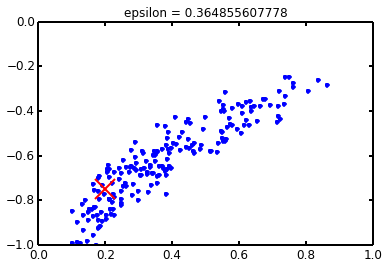

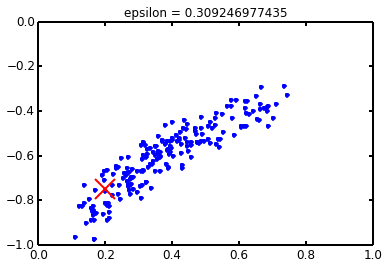

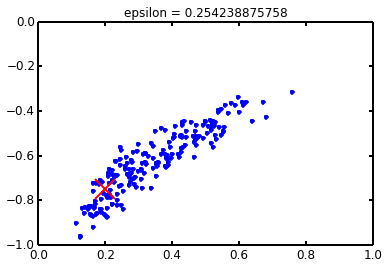

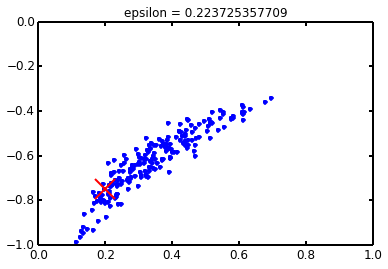

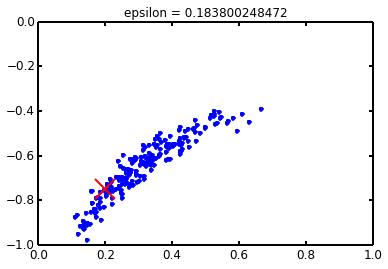

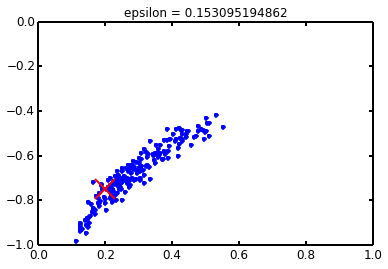

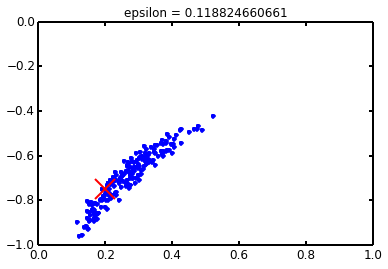

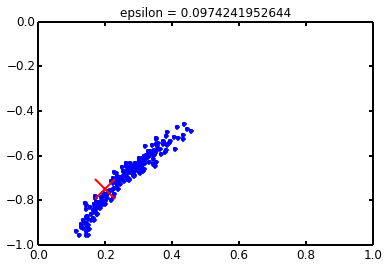

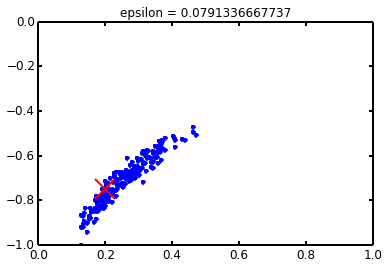

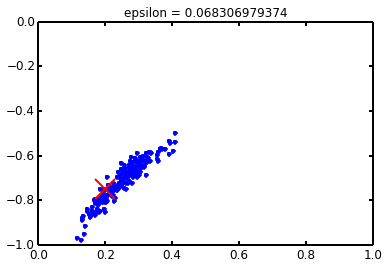

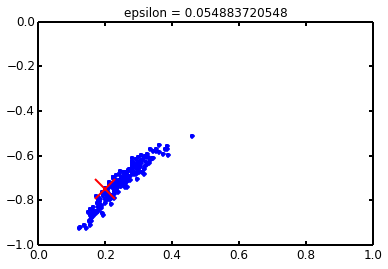

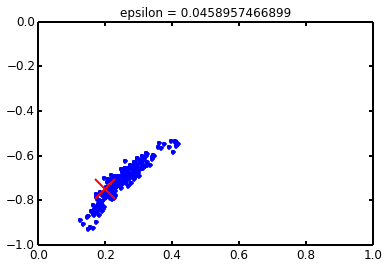

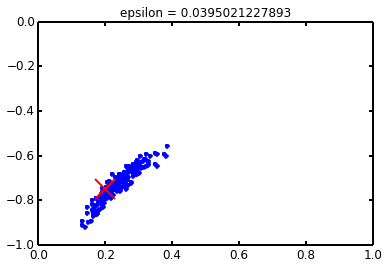

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

for i in range(15):
    plt.figure()
    plt.plot(pmc_posterior[i][0][0,:], pmc_posterior[i][0][1,:], '.');
    plt.title('epsilon = {}'.format(pmc_posterior[i]['epsilon']))
    plt.plot(0.2, -0.75, 'rx', ms=20)
    plt.xlim(0,1)
    plt.ylim(-1, 0)

In [22]:
%timeit pop.observe(new_orbits=True)

10 loops, best of 3: 84.1 ms per loop
